# Libs

In [1]:
from torchvision.datasets import CelebA
import os
import torch.nn as nn
import glob
import os
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import torch
import math
# main libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.nn import functional as F
from torch import nn
from torch import optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset
import math
import torchvision.transforms.functional as TF
import cv2
from keras.utils import image_dataset_from_directory
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.nn.parameter import Parameter

from torch.nn import init
from torchvision.utils import make_grid
from collections import OrderedDict

import torch
from torch.utils.data import Dataset

from skimage import transform
import skimage.io as io
import numpy as np
from torchvision.utils import save_image

# Helper Functions

In [2]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [3]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 128, 128)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [4]:
def ploter(image, image_hat):
    """
    (H, W)
    """
    plt.figure()
    plt.subplot(1,2,1)
    #plt.imshow(image_hat, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(image_hat)
    plt.tight_layout()
    plt.title("Reconstruct")

    plt.subplot(1,2,2)
    #plt.imshow(image, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(image)
    plt.tight_layout()
    plt.title("Original")

    plt.show()

# Generator

In [5]:
os.chdir("/content/drive/MyDrive/AD Last Research")

FileNotFoundError: [WinError 2] The system cannot find the file specified: '/content/drive/MyDrive/AD Last Research'

In [7]:
from mymodels.generator import Generator_XL, Generator_S

In [8]:
generator = Generator_XL(
    z_dim=100,
    c_dim=0,
    w_dim=0,
    img_resolution=32,
    img_channels=3,
    ngf=8,
    cond=0,
)

In [9]:
count_parameters(generator)

758863

In [10]:
generator = Generator_S(features=64,
                        img_size=32,
                        latent_dim=100,
                        channels=3)
count_parameters(generator)

1051139

# Discriminator

In [11]:
from mymodels.discriminator import Discriminator

In [12]:
discriminator = Discriminator(features=32, channels=3, img_size=32, optimization='gan')

In [13]:
count_parameters(discriminator)

390337

# Dataset

In [14]:
from dataset import customdataset

In [15]:
img_size = 32
channels = 3
batch_size = 10

In [16]:
# Train
train_dataset_normal = customdataset.get_nomral_dataset_train(dataset_name='cifar10',
                                                               label=0,
                                                               img_size=img_size, channels=channels,
                                                               data_path='./CIFAR10', download=True)

train_indx = SubsetRandomSampler(list(range(1000)))
train_loader_normal = DataLoader(train_dataset_normal, batch_size=batch_size, sampler=train_indx)

Files already downloaded and verified


In [17]:
# Test
test_dataset_normal,  test_dataset_ano = customdataset.get_dataset_test(dataset_name='cifar10',
                                                                         normal_label=0, ano_label=2,
                                                                         img_size=img_size, channels=channels,
                                                                         data_path="./CIFAR10", download=True)

test_loader_normal = DataLoader(test_dataset_normal, batch_size = test_dataset_normal.__len__())
test_loader_ano = DataLoader(test_dataset_ano, batch_size = test_dataset_ano.__len__())

Files already downloaded and verified
Files already downloaded and verified


# Vanilla GAN

### Generator LAB
mikhaham bbinam Generator man asan potential in ro dare k CIFAR10 ro besaze??? age mostaghim b khoroji tasavir ro bedaham??

In [78]:
device = 'cuda'
latent_dim = 100

In [80]:
# Nets
generator = Generator_XL(
    z_dim=latent_dim,
    c_dim=0,
    w_dim=0,
    img_resolution=img_size,
    img_channels=channels,
    ngf=8,
    cond=0,
).to(device)

generator = Generator_S(features=64,
                        img_size=img_size,
                        latent_dim=latent_dim,
                        channels=channels).to(device)

In [81]:
# Loss & Optimizers
critic = nn.MSELoss()
optimizer_G = optim.Adam(generator.parameters())

In [82]:
# WRONG

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [83]:
generator = generator.apply(weights_init_normal)

In [84]:
device = 'cpu'
generator = generator.to(device)

init_epoch = 0
num_epochs = 100
sample_interval = 10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


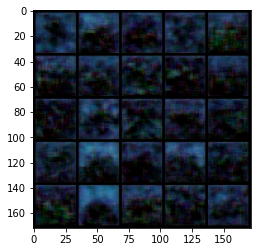

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


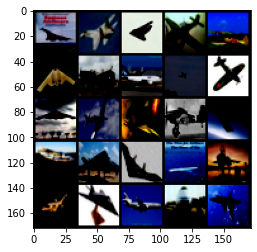

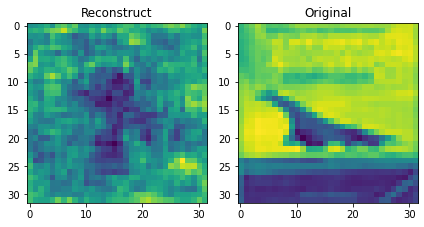

KeyboardInterrupt: 

In [42]:
for epoch in range(init_epoch, num_epochs+1):

    # Load Train Data ##############################################
    for i, (real_images, _) in enumerate(train_loader_normal):

        real_images = real_images.to(device)

        # Train Generator ########################################
        optimizer_G.zero_grad()
        z = torch.FloatTensor(np.random.normal(0, 1, (real_images.shape[0], latent_dim))).to(device)
        gen_imgs = generator(z)
        g_loss = critic(gen_imgs, real_images)
        g_loss.backward()
        optimizer_G.step()


    # Load Test Data ##############################################
    if epoch % sample_interval ==0:
        for _, (real_images, _) in enumerate(test_loader_normal):
            # Preprocessing ##############################################
            real_images = real_images.to(device)

            # MRI Image
            #real_images = real_images.unsqueeze(1).cuda()
            #real_images = real_images.repeat(1,3,1,1)

            z = torch.FloatTensor(np.random.normal(0, 1, (real_images.shape[0], latent_dim))).to(device)
            gen_imgs = generator(z)

            # Visualization ##############################################
            show_tensor_images(gen_imgs, size=(channels, img_size, img_size))
            show_tensor_images(real_images, size=(channels, img_size, img_size))

            num = math.floor(np.random.uniform(0, len(test_loader_normal)))
            ploter(real_images.detach().cpu()[num][0], gen_imgs.detach().cpu()[num][0])

### Unet
inja gharare k Encoder UNET yad begire k ch chiza ei az tasvire normal mohemme baraye baz sazi va behtarin feature ha ro extract kone.

sepas, az encoder esh estefade konam faghat jori k fake images ha b in features ha nazdik shavad

In [85]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=3, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")


        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x, discriminator):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        if discriminator:
            return bottleneck.flatten(1)
        else:
            return torch.tanh(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [86]:
# TEST
N, C, H, W = 10, 3, 32, 32

unet = UNet(3,3,8).cuda()
x = torch.ones(N, C, H, W).cuda()

unet(x, discriminator=True).shape

torch.Size([10, 512])

In [68]:
device = 'cpu'
unet = UNet(channels, channels, init_features=32).to(device)
optimizer_UNet = optim.Adam(unet.parameters())
critic = nn.MSELoss()

In [69]:
loss_min = np.Inf
best_unet = {}

for epoch in range(1000):
    # Training
    unet.train()
    for real_images, _ in train_loader_normal:
        real_images = real_images.to(device)
        optimizer_UNet.zero_grad()
        real_images_hat = unet(real_images, discriminator=False)
        loss = critic(real_images_hat, real_images)
        loss.backward()
        optimizer_UNet.step()

    # Eval
    unet.eval()
    for real_images, _ in test_loader_normal:
        real_images = real_images.to(device)
        real_images_hat = unet(real_images, discriminator=False)
        loss = critic(real_images_hat, real_images)

    # Save best Model
    loss_Total = loss.item()
    print(f"Epoch{epoch} : Loss = {loss_Total}")
    if loss_Total<loss_min:
        loss_min = loss_Total
        best_unet['epoch'] = epoch
        best_unet['loss'] = loss_Total
        best_unet['unet_parameters'] = unet.state_dict()

Epoch0 : Loss = 0.010463058017194271


KeyboardInterrupt: 

### Best Discirminator (Unet)
estedafe kon az encoder esh baraye GAN

In [72]:
device = 'cuda'
unet = UNet(channels, channels, init_features=32).to(device)
unet.load_state_dict(
    best_unet['unet_parameters']
)

<All keys matched successfully>

### GAN

### Hyperparameters

In [74]:
device = 'cuda'
latent_dim = 100

### All in One

In [75]:
# Nets
generator = Generator_XL(
    z_dim=latent_dim,
    c_dim=0,
    w_dim=0,
    img_resolution=img_size,
    img_channels=channels,
    ngf=8,
    cond=0,
).to(device)

generator = Generator_S(features=64,
                        img_size=img_size,
                        latent_dim=latent_dim,
                        channels=channels).to(device)

#discriminator = Discriminator(features=16, channels=channels, img_size=img_size, optimization='gan').to(device)

In [76]:
# Loss & Optimizers
#adversarial_loss = nn.BCELoss()
critic = nn.MSELoss()
optimizer_G = optim.Adam(generator.parameters())
#optimizer_D = optim.Adam(discriminator.parameters())

### Re-Init

In [21]:
# WRONG

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [39]:
generator = generator.apply(weights_init_normal)
#discriminator = discriminator.apply(weights_init_normal)

### Train

In [89]:
device = 'cpu'
generator = generator.to(device)
unet = unet.to(device)

init_epoch = 0
num_epochs = 100
sample_interval = 10

Epoch0 : Loss = 0.467617392539978


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


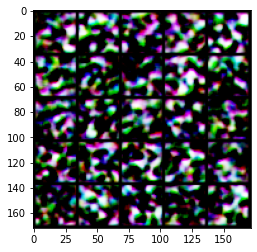

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


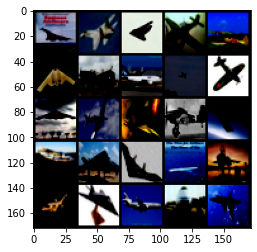

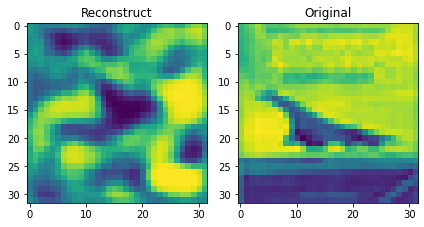

Epoch1 : Loss = 0.46363264322280884


KeyboardInterrupt: 

In [90]:
loss_min = np.Inf
best_gen = {}

for epoch in range(init_epoch, num_epochs+1):
    total_G_loss = 0.0
    # Load Train Data ##############################################
    for i, (real_images, _) in enumerate(train_loader_normal):
        # Preprocessing ##############################################
        real_images = real_images.to(device)
        # Train Generator ########################################
        optimizer_G.zero_grad()
        z = torch.FloatTensor(np.random.normal(0, 1, (real_images.shape[0], latent_dim))).to(device)
        gen_imgs = generator(z)
        g_loss = critic(
            unet(gen_imgs, discriminator=True), unet(real_images, discriminator=True)
        )
        g_loss.backward()
        optimizer_G.step()
        total_G_loss += g_loss.cpu().detach().numpy()


    # Save Best Generator
    for real_images, _ in test_loader_normal:
        real_images = real_images.to(device)
        z = torch.FloatTensor(np.random.normal(0, 1, (real_images.shape[0], latent_dim))).to(device)
        gen_imgs = generator(z)
        g_loss = critic(
            unet(gen_imgs, discriminator=True), unet(real_images, discriminator=True)
        )
    # Save best Model
    loss_Total = g_loss.item()
    print(f"Epoch{epoch} : Loss = {loss_Total}")
    if loss_Total<loss_min:
        loss_min = loss_Total
        best_unet['epoch'] = epoch
        best_unet['loss'] = loss_Total
        best_unet['gen_parameters'] = generator.state_dict()



    # Load Test Data ##############################################
    if epoch % sample_interval ==0:
        for _, (real_images, _) in enumerate(test_loader_normal):

            # Visualization ##############################################
            show_tensor_images(gen_imgs, size=(channels, img_size, img_size))
            show_tensor_images(real_images, size=(channels, img_size, img_size))

            num = math.floor(np.random.uniform(0, len(test_loader_normal)))
            ploter(real_images.detach().cpu()[num][0], gen_imgs.detach().cpu()[num][0])

        # SAVE ##############################################
        """
        torch.save({"epoch": epoch,
        "state_dict_G": generator.state_dict(),
        "state_dict_D": discriminator.state_dict(),
        "optimizer_G": optimizer_G.state_dict(),
        "optimizer_D": optimizer_D.state_dict()
        }, root_save + f"/epoch_{epoch}.pt")
        """

### TSNE

In [96]:
from sklearn.manifold import TSNE

def get_2d_tsne(x):
    tsne = TSNE(n_components=2, random_state=0,  learning_rate='auto', init='random')
    x_2d = tsne.fit_transform(x)

    return x_2d

In [97]:
device = 'cpu'
generator = generator.to(device)
unet = unet.to(device)

for _, (real_images, _) in enumerate(test_loader_normal):
    # Preprocessing ##############################################
    real_images = real_images.to(device)

    z = torch.FloatTensor(np.random.normal(0, 1, (real_images.shape[0], latent_dim))).to(device)
    gen_imgs = generator(z)

In [98]:
d1 = unet(real_images, discriminator=True)
d2 = unet(gen_imgs, discriminator=True)

In [99]:
d1_2d = get_2d_tsne(d1.detach().cpu())
d2_2d = get_2d_tsne(d2.detach().cpu())

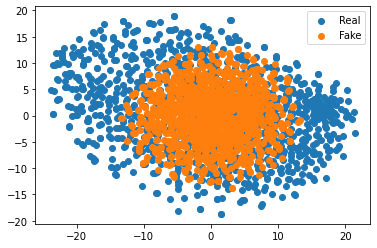

In [100]:
plt.figure()
plt.scatter(d1_2d[:,0], d1_2d[:,1], label='Real')
plt.scatter(d2_2d[:,0], d2_2d[:,1], label='Fake')
plt.legend()

# WGAN
hanoz kar nashode hast!

### GP

In [ ]:
from torch.autograd import Variable
Tensor = torch.cuda.FloatTensor # Cuda
import torch.autograd as autograd

def compute_gradient_penalty(discriminator, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1))).to(real_samples.device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = discriminator(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

### Hyperparameters

In [ ]:
device = 'cuda'
latent_dim = 100
n_critic = 5
lambda_gp =10
lr = 2e-3

### All in One

In [ ]:
# Nets
generator = Generator(
    z_dim=latent_dim,
    c_dim=0,
    w_dim=0,
    img_resolution=img_size,
    img_channels=channels,
    ngf=8,
    cond=0,
).to(device)

discriminator = Discriminator(features=32, channels=channels, img_size=img_size, optimization='wgan').to(device)

In [ ]:
# Loss & Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr,  betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr,  betas=(0.5, 0.999))

### Re-Init

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [ ]:
generator = generator.apply(weights_init_normal)
discriminator = discriminator.apply(weights_init_normal)

### Train

In [ ]:
init_epoch = 0
num_epochs = 100
sample_interval = 10

In [ ]:
for epoch in range(init_epoch, num_epochs+1):
    total_G_loss = 0.0
    total_D_loss = 0.0

    # Load Train Data ##############################################
    for i, (real_images, _) in enumerate(train_loader_normal):

        # Preprocessing ##############################################
        real_images = real_images.to(device)
        # MRI
        #real_images = real_images.unsqueeze(1).cuda()
        #real_images = real_images.repeat(1,3,1,1)


        # Train Discriminator ########################################
        z = torch.FloatTensor(np.random.normal(0, 1, (real_images.shape[0], latent_dim))).to(device)
        gen_imgs = generator(z)
        optimizer_D.zero_grad()
        real_validity = discriminator(real_images)
        fake_validity = discriminator(gen_imgs.detach())
        gradient_penalty = compute_gradient_penalty(discriminator, real_images, gen_imgs.detach())
        d_loss_adv = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty


        #d_loss_layers = discriminator_layers_loss(discriminator, vgg, real_images, lamda = 0.01)


        d_loss = d_loss_adv #+ d_loss_layers
        d_loss.backward()
        optimizer_D.step()
        total_D_loss += d_loss.cpu().detach().numpy()



        # Train Generator ########################################
        if i % n_critic == 0:
            z = torch.FloatTensor(np.random.normal(0, 1, (real_images.shape[0], latent_dim))).to(device)
            gen_imgs = generator(z)

            optimizer_G.zero_grad()
            fake_validity = discriminator(gen_imgs)
            g_loss_adv = -torch.mean(fake_validity)

            g_loss = g_loss_adv
            g_loss.backward()
            optimizer_G.step()
            total_G_loss += g_loss.cpu().detach().numpy()


    # Load Test Data ##############################################
    if epoch % sample_interval ==0:
        for _, (real_images, _) in enumerate(test_loader_normal):
            # Preprocessing ##############################################
            real_images = real_images.to(device)
            # MRI Image
            #real_images = real_images.unsqueeze(1).cuda()
            #real_images = real_images.repeat(1,3,1,1)

            z = torch.FloatTensor(np.random.normal(0, 1, (real_images.shape[0], latent_dim))).to(device)
            gen_imgs = generator(z)

            # Visualization ##############################################
            show_tensor_images(gen_imgs, size=(channels, img_size, img_size))
            show_tensor_images(real_images, size=(channels, img_size, img_size))
            num = math.floor(np.random.uniform(0, len(test_loader_normal)))
            ploter(real_images.detach().cpu()[num][0], gen_imgs.detach().cpu()[num][0])


        # Losses ##############################################
        print("[Epoch {}/{}] \t[D loss: {:.3f}] \t[G loss: {:.3f}]".format(epoch, num_epochs, total_D_loss, total_G_loss))
        # SAVE ##############################################
        """
        torch.save({"epoch": epoch,
        "state_dict_G": generator.state_dict(),
        "state_dict_D": discriminator.state_dict(),
        "optimizer_G": optimizer_G.state_dict(),
        "optimizer_D": optimizer_D.state_dict()
        }, root_save + f"/epoch_{epoch}.pt")
        """